In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

This tutorial explains how to train a machine learning model for the electronic Hamiltonian of a periodic system.

First, import the necessary packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import torch
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt

import chemiscope

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping

from mlelec.data.qmdataset import QMDataset
from mlelec.data.mldataset import MLDataset
from mlelec.data.derived_properties import compute_eigenvalues

from mlelec.utils.pbc_utils import blocks_to_matrix

from mlelec.models.equivariant_nonlinear_lightning import LitEquivariantModel, MLDatasetDataModule, MSELoss

from mlelec.callbacks.logging import LoggingCallback
from mlelec.callbacks.progress_bar import ProgressBar

from mlelec.utils.plot_utils import plot_bands_frame

Using PyTorch backend.


# Step 0: Prepare Data Set

In [3]:
workdir = '/scratch/pegolo/tutorial'
every = 5

## Load structures and DFT data

In [4]:
orbitals = {
     'sto-3g': {
         6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
     }, 
}

basis = 'sto-3g'

In [5]:
qmdata = QMDataset.from_file(
    frames_path = f'{workdir}/C2.xyz', 
    fock_realspace_path = f'{workdir}/{basis}/graphene_fock.npy', 
    overlap_realspace_path = f'{workdir}/{basis}/graphene_ovlp.npy',
    kmesh_path = f'{workdir}/{basis}/kmesh.dat',
    dimension = 2, 
    device = 'cpu', 
    orbs_name=basis, 
    orbs=orbitals[basis], 
    frame_slice = f'::{every}',
)

### Visualize the equivariant structure of the Hamiltonians

In [6]:
from mlelec.utils.animation import lissajous_euler, rotated_matrices
from IPython.display import HTML
from mlelec.utils.target_utils import get_targets
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from ase.visualize.plot import plot_atoms

We choose a structure (e.g., the first) from the QM data set

In [7]:
init_frame = qmdata.structures[0].copy()

We reduce the out-of-plane dimension size for ease of visualization

In [8]:
cell = init_frame.cell.array
cell[2, 2] = 1
init_frame.set_cell(cell)

We get the coupled representation of the Hamiltonians

In [9]:
blocks = get_targets(qmdata, orbitals_to_properties=True)

We rotate the structure along a path in 3D space, and we compute the relative rotation of the Hamiltonian matrices. 

`lissajous_euler` is a function returning <a href="https://en.wikipedia.org/wiki/Euler_angles">Euler angles</a> representing rotations of a vector along a <a href="https://en.wikipedia.org/wiki/Lissajous_curve">Lissajous curve</a>.

In [10]:
rot_struc, rot_H = rotated_matrices(init_frame, blocks, 0, orbitals['sto-3g'], lissajous_euler, params=np.linspace(0, 2 * np.pi, 200))

Now we set up an animation of the structure's rotations and the corresponding rotated Hamiltonian.

To do so, we can define a `plot_frame` function to plot a single frame of this trajectory.

In [11]:
def plot_frame(i):
    # Clear the axes
    for ax in axes:
        ax.clear()
        ax.set_aspect('equal')
        ax.set_axis_off()

    # Plot the first subplot, containing a pictorial representation of the structure
    ax = axes[0]
    plot_atoms(rot_struc[i], ax=ax)
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)

    # Plot the second subplot, containing a colormap of the Hamiltonian matrix
    ax = axes[1]
    ax.matshow(np.abs(rot_H[i][0][0, 0, 0]), norm=LogNorm(vmin=1e-5, vmax=10))

Finally, we define figure and axes and set up the `matplotlib` animation:

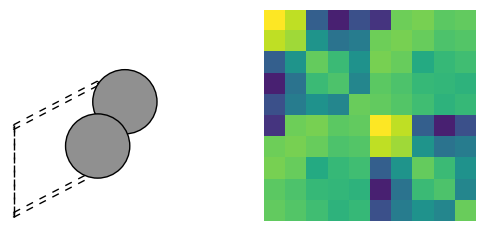

In [12]:
# Setup the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Create the animation
anim = FuncAnimation(fig, plot_frame, frames=len(rot_struc), interval=200)

In [13]:
from IPython.display import HTML
HTML(anim.to_jshtml())

## Instantiate machine learning data set

Define the hyperparameters for the ACDC descriptors. There are hypers for the single-center (SC) $\lambda$-SOAP and two-center (TC) descriptors.

The single and two-center descriptors have very similar hyperparameters, except for the cutoff radius, which is larger for the two-center one, in order to explicitly include far away pairs of atoms.

In [6]:
SC_HYPERS = {
    'cutoff': 3.0,
    'max_radial': 10,
    'max_angular': 8,
    'atomic_gaussian_width': 0.5,
    'center_atom_weight': 1,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}}
}

In [7]:
TC_HYPERS = {
    'cutoff': 6.0,
    'max_radial': 10,
    'max_angular': 8,
    'atomic_gaussian_width': 0.3,
    'center_atom_weight': 1.0,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}}
}

We then use the above defined hyperparameters to compute the descriptor and initialize a `MLDataset` instance.

In addition to computing the descriptors, `MLDataset` takes the data stored in the `QMDataset` instance and puts it in a form required to train a ML model.

`item_names` contains the names of the quantities we want to compute to target in the ML model training or to be able to access later.

`fock_blocks` is a `metatensor.Tensormap` containing the coupled blocks the Hamiltonian matrices have been divided into.

In [153]:
mldata = MLDataset(
    qmdata, 
    item_names = ['fock_blocks', 'overlap_kspace'],
    hypers_atom = SC_HYPERS,
    hypers_pair = TC_HYPERS,
    lcut = 4,
    train_frac = 0.7,
    val_frac = 0.2,
    test_frac = 0.1,
    shuffle = True,
    model_basis = orbitals['sto-3g'],
)

cpu pair features
cpu single center features
cpu single center features


In [9]:
from mlelec.models.equivariant_nonlinear_model import EquivariantModel

In [112]:
model = EquivariantModel(
    mldata,
    nhidden=0,
    nlayers=0,
    set_bias=True
)

In [121]:
model.init_with_ridge_weights(mldata.items.fock_blocks)

# Step 1: Build a machine learning model for the electronic Hamiltonian of graphene in a minimal basis

Instantiate a `pytorch_lightning` data module from the `MLDataset` instance

In [154]:
data_module = MLDatasetDataModule(mldata, batch_size=8, num_workers=0)

In [155]:
model = LitEquivariantModel(
    mldata=mldata,
    # The number of hidden layers
    nlayers=2,
    # The number of neurons in each hidden layer
    nhidden=8,
    # What nonlinear activation function to apply to the invariant hidden features
    activation='SiLU',
    # Type of optimizer
    optimizer='adam',
    # Initial learning rate for the optimizer
    learning_rate=1e-3,
    # learning rate scheduler settings
    lr_scheduler_patience=10,
    lr_scheduler_factor=0.8,
    lr_scheduler_min_lr=1e-6,
    # Use the mean square error as loss function
    loss_fn=MSELoss(),
)

In [179]:
model = LitEquivariantModel(
    mldata=mldata,
    nlayers=0,
    nhidden=0,
    init_from_ridge=True,
    optimizer='LBFGS',
    learning_rate=1e-3,
    lr_scheduler_patience=10,
    lr_scheduler_factor=0.8,
    lr_scheduler_min_lr=1e-6,
    loss_fn=MSELoss(),
)

In [181]:
out=model.forward(mldata.features)

This is what the architecture of one of the submodels we use for each Hamiltonian block looks like.

Here we visualize the models' graphs using `torchviz`

In [79]:
from torchviz import make_dot
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys_integrated

In [80]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dots = {}
    for k in model.model.model.in_keys:
        submodel = model.model.model.get_module(k)    
        descriptor = map_targetkeys_to_featkeys_integrated(mldata.features, k).values
        output = submodel.forward(descriptor)
        dots[tuple(k.values.tolist())] = make_dot(output, dict(submodel.named_parameters())) 
        dots[tuple(k.values.tolist())].graph_attr.update(size='150,150')

The first submodel

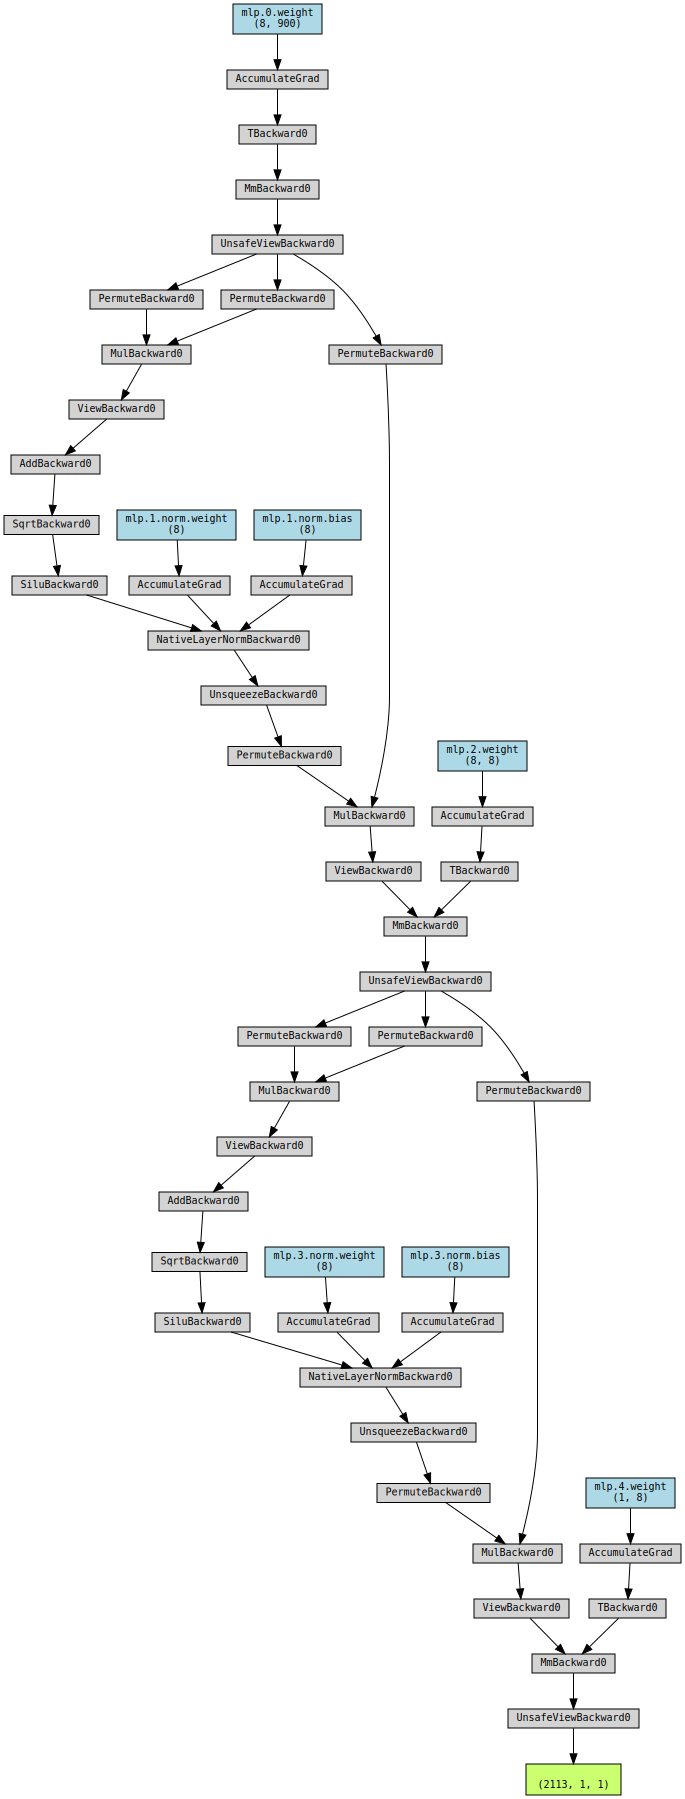

In [81]:
list(dots.values())[0]

We apply nonlinear activation to invariants obtained from the equivariant blocks

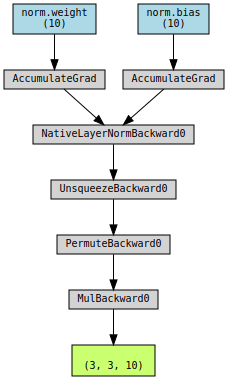

In [82]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from mlelec.models.equivariant_nonlinear_model import EquivariantNonLinearity
    m = EquivariantNonLinearity(torch.nn.SiLU(), layersize = 10)
    y = m.forward(torch.randn(3,3,10))
    dot = make_dot(y, dict(m.named_parameters()))
    dot.graph_attr.update(size='150,150')
dot

## Set up the training loop

We use the `TensorBoardLogger` from `pytorch_lightning` to follow the training

In [83]:
logger = TensorBoardLogger("tb_logs", name="graphene")
progress_bar = ProgressBar()
logger_callback = LoggingCallback(log_every_n_epochs = 5)

We set up an early stopping criterion to stop the training when the validation loss function stops decreasing.

In [84]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=10,
    verbose=False,
    mode='min'
)

We define a `lighting.pytorch.Trainer` instance to handle the training loop.

In [85]:
trainer = pl.Trainer(
    max_epochs=2000, 
    accelerator='cpu', 
    check_val_every_n_epoch=10,
    callbacks=[early_stopping, progress_bar]
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [86]:
trainer.fit(model, data_module)


  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | EquivariantModel | 102 K  | train
------------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.410     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

# Evaluate model accuracy

We compute the test set loss to assess the model accuracy on an unseen set of structures

In [87]:
trainer.test(model, data_module)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.004061670816685003    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.004061670816685003}]

We can compute the predicted Hamiltonians from the trained model

In [183]:
predicted_blocks = model.forward(mldata.features)

And convert the coupled blocks to Hamiltonian matrices

In [184]:
frames_dict = {
    A: qmdata.structures[A]
    for A in range(len(qmdata))
}
HT = blocks_to_matrix(predicted_blocks, orbitals['sto-3g'], frames_dict, detach=True)
Hk = qmdata.bloch_sum(HT, is_tensor=True)

We can then compute the eigenvalues to assess the model accuracy in predicting the band structure

In [185]:
target_eigenvalues = compute_eigenvalues(qmdata.fock_kspace, qmdata.overlap_kspace)
predicted_eigenvalues = compute_eigenvalues(Hk, qmdata.overlap_kspace)

Text(0, 0.5, 'Predicted eigenvalues (eV)')

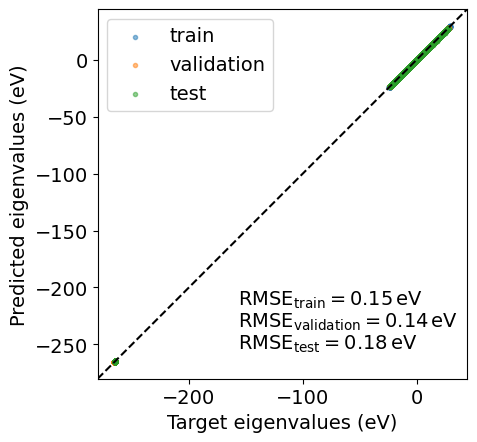

In [186]:
Hartree = 27.211386024367243 # eV

plt.rcParams['font.size'] = 14
fig, ax = plt.subplots()
ax.set_aspect('equal')

x_text = 0.38
y_text = 0.2
d = 0.06

for i, (idx, label) in enumerate(zip([mldata.train_idx, mldata.val_idx, mldata.test_idx], ['train', 'validation', 'test'])):
    
    target = torch.stack([target_eigenvalues[i] for i in idx]).flatten().detach()*Hartree
    prediction = torch.stack([predicted_eigenvalues[i] for i in idx]).flatten().detach()*Hartree

    non_core_states = target > -100
    rmse = np.sqrt(np.mean((target.numpy()[non_core_states]-prediction.numpy()[non_core_states])**2))
    ax.scatter(target, prediction, marker = '.', label = label, alpha = 0.5)
    ax.text(x = x_text, y = y_text - d*i, s = fr'$\mathrm{{RMSE_{{{label}}}={rmse:.2f}\,eV}}$', transform = ax.transAxes)

xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], '--k')
ax.set_xlim(xmin,xmax)
ax.set_ylim(xmin,xmax)
ax.legend()
ax.set_xlabel('Target eigenvalues (eV)')
ax.set_ylabel('Predicted eigenvalues (eV)')

## Graphene band structure

Apart from the eigenvalues on a mesh in the Brillouin zone, we can use the real-space Hamiltonians predicted by the model to compute the band structure along high-symmetry paths.

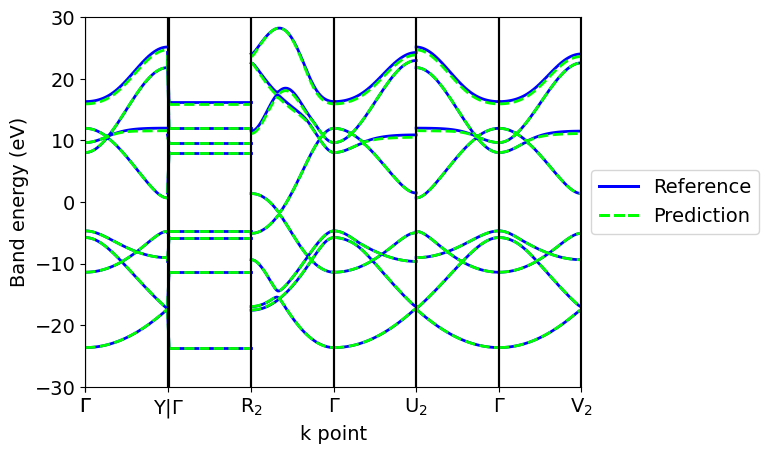

In [187]:
fig, ax = plt.subplots()

idx = 0

handles = []

# Plot reference
ax, h_ref = plot_bands_frame(qmdata.fock_realspace[idx], idx, qmdata, ax = ax, color = 'blue', lw = 2)

# Plot prediction
ax, h_pred = plot_bands_frame(HT[idx], idx, qmdata, ax = ax, color = 'lime', ls = '--', lw = 2)

ax.set_ylim(-30,30)
ax.legend([h_ref, h_pred], ['Reference', 'Prediction'], loc = 'center left', bbox_to_anchor = (1, 0.5))